# HSE 2019 ML (bachelors 3rd course)
## Homework #4
### Student: Igor Tukh

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [36]:
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict

In [3]:
DATASETS_DIR = 'datasets'

def load_csv_dataset(dataset_name, label_name='label', with_header=True):    
    dataset_path = os.path.join(DATASETS_DIR, dataset_name)
    if label_name is not None:
        dataset = pd.read_csv(dataset_path)
        data_columns = np.array([name for name in dataset.columns if name != label_name])
        return dataset[data_columns], dataset[np.array([label_name])]
    else:
        return pd.read_csv(dataset_path) if with_header else pd.read_csv(dataset_path, header=None)

### Regression

#### Datasets: noisysine.csv, hydrodynamics.csv. Both should be split into train and validate datasets (80% / 20%).

#### In every task, you need to calculate the $R^2$ score (for both datasets) and draw the resulting function on the noisysine dataset.


#### 1) (3) Implement linear and polynomial regression algorithms (for noisysine use the powers from 2 to 5, for hydrodynamics use the power of 2). No regularization. 

#### 2) (2) Implement a ridge regression algorithm and optimize the regularization parameter for every case from task #1.

#### 3) (3) Use the LASSO regression algorithm for every case from task #1 (i.e., from the sklearn library). Output the number of used features.

### Global and Local Search
#### Dataset: tsp.csv - coordinates of points to visit.
#### In every task, you need to visualize the best-found path and output its length. The path is not cyclical, i.e., the starting and finishing points are not the same.

#### NOTICE - the distance should be in L1 (avenues and streets). The path should be drawn as L1 as well.

In [4]:
def plot_route(points, route, plot_name=''):
    plt.clf()
    plt.scatter(points[:, 0], points[:, 1])
    plt.title(plot_name)
    for cur_point_ind, next_point_ind in zip(route[:-1], route[1:]):
        plt.plot([points[cur_point_ind][0], points[next_point_ind][0]],
                 [points[cur_point_ind][1], points[cur_point_ind][1]], color='black')
        plt.plot([points[next_point_ind][0], points[next_point_ind][0]],
                 [points[cur_point_ind][1], points[next_point_ind][1]], color='black')
    plt.show()

In [5]:
np.random.seed(2392)

In [6]:
def get_manhattan_distance(first, second):
    return np.sum([np.abs(first[i] - second[i]) for i in range(first.shape[0])])

In [7]:
def get_route_length(points, route):
    return np.sum([get_manhattan_distance(points[first], points[second]) 
                   for first, second in zip(route[:-1], route[1:])])

In [8]:
def prepare_points():
    X = load_csv_dataset('tsp.csv', label_name=None, with_header=False)
    X = X.to_numpy()[:, [1, 2]].reshape(-1, 2)
    return X

Let's look at the initial order

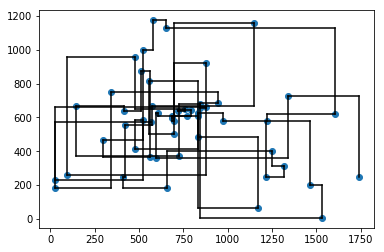

Length: 27815


In [9]:
def plot_initial():
    X = prepare_points()
    plot_route(X, np.arange(X.shape[0]))
    print('Length: {}'.format(get_route_length(X, np.arange(X.shape[0]))))

plot_initial()

#### 4) (2) Implement a Monte-Carlo search.

In [10]:
def get_monte_carlo_search_route(points, iterations_amount=10**5):
    n = points.shape[0]
    current_perm = np.random.permutation(n)
    current_length = get_route_length(points, current_perm)
    for _ in tqdm(range(iterations_amount)):
        next_perm = np.random.permutation(n)
        next_length = get_route_length(points, next_perm)
        if next_length < current_length:
            current_length = next_length
            current_perm = next_perm
    
    return current_perm, current_length

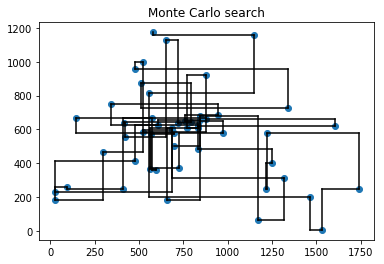

Length: 26695


In [11]:
def task4():
    X = prepare_points()
    route, length = get_monte_carlo_search_route(X)
    plot_route(X, route, 'Monte Carlo search')
    print('Length: {}'.format(length))
    
task4()

As we can see, Monte Carlo search with $10^6$ iterations is a bit better than the initial order

#### 5) (2) Implement a random walk search.

Let's implement a random walk, where we choice random (with distribution ~ inverse distances) neighbor (not visited yet point). And then we will repeat the process several times

In [12]:
def random_walk_iteration(points):
    n = points.shape[0]
    perm = []
    visited = np.zeros(n, dtype=np.bool)
    prev_point_ind = -1
    dists = np.array([[get_manhattan_distance(points[first], points[second]) if first != second else 1 
                       for first in range(n)] for second in range(n)])
    inv_dists = 1. / dists
    for _ in range(n):
        not_visited_points = np.where(visited == False)[0]
        if prev_point_ind == -1:
            next_point_ind = np.random.choice(not_visited_points)
        else:
            current_dists = inv_dists[prev_point_ind, not_visited_points]
            probabilities = current_dists / np.sum(current_dists)
            next_point_ind = np.random.choice(not_visited_points, p=probabilities)
        perm.append(next_point_ind)
        visited[next_point_ind] = True
        prev_point_ind = next_point_ind
        
    return np.array(perm)

def get_random_walk_route(points, iterations_amount=10**3):
    current_perm = None
    current_length = 0
    for _ in tqdm(range(iterations_amount)):
        perm = random_walk_iteration(points)
        length = get_route_length(points, perm)
        if current_perm is None or length < current_length:
            current_length = length
            current_perm = perm
    
    return current_perm, current_length

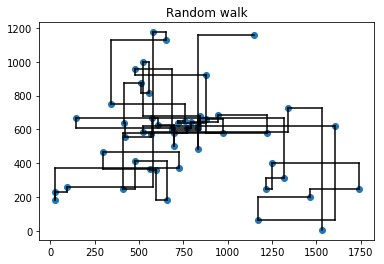

Length: 20765


In [15]:
def task5():
    X = prepare_points()
    route, length = get_random_walk_route(X)
    plot_route(X, route, 'Random walk')
    print('Length: {}'.format(length))

task5()

As we can see, such a random walk is much better than the Monte Carlo search and initial order both

#### 6) (4) Implement a hill climb algorithm.


In [24]:
def get_neighbour_permutations(permutation):
    n = permutation.shape[0]
    pairs_to_swap = [(first, second) for first in range(n) for second in range(n) if first != second]
    permutations = []
    for first, second in pairs_to_swap:
        new_perm = permutation.copy()
        new_perm[first], new_perm[second] = new_perm[second], new_perm[first]
        permutations.append(new_perm)
    return np.array(permutations)

def get_hill_climb_route(points, iterations_amount=10, inner_iterations_amount=10):
    n = points.shape[0]
    best_perm = np.random.permutation(n)
    best_score = get_route_length(points, best_perm)
    for _ in tqdm(range(iterations_amount)):
        perm = np.random.permutation(n)
        perm_score = get_route_length(points, perm)
        for _ in range(inner_iterations_amount):
            next_perms = get_neighbour_permutations(perm)
            best_next_perm = None
            best_next_perm_score = 0
            for next_perm in next_perms:
                score = get_route_length(points, next_perm)
                if best_next_perm is None or best_next_perm_score > score:
                    best_next_perm_score = score
                    best_next_perm = next_perm
            if best_next_perm_score < perm_score:
                perm = best_next_perm
                perm_score = best_next_perm_score
            else:
                break
        if perm_score < best_score:
            best_score = perm_score
            best_perm = perm
        print('Current lowest length is {}'.format(best_score))
    return best_perm, best_score

Current lowest length is 20485
Current lowest length is 20000
Current lowest length is 20000
Current lowest length is 18130
Current lowest length is 18130
Current lowest length is 18130
Current lowest length is 18130
Current lowest length is 18130
Current lowest length is 18130
Current lowest length is 18130



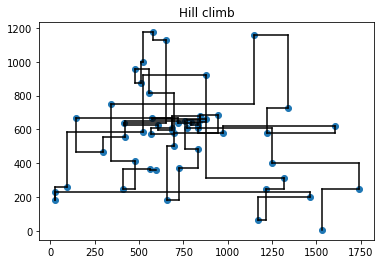

Length: 18130


In [25]:
def task6():
    X = prepare_points()
    route, length = get_hill_climb_route(X)
    plot_route(X, route, 'Hill climb')
    print('Length: {}'.format(length))
task6()

As we can see, hill climb algorithm is better than previous approaches

#### 7) (6) Implement a simulated annealing algorithm.

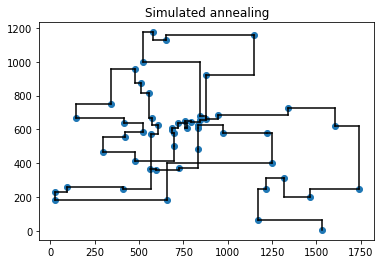

Length: 11690.0


In [35]:
def neighbour_delta(points, perm, index):
    delta = 0.
    if index != 0:
        delta += get_manhattan_distance(points[perm[index - 1]], points[perm[index]])
    if index != perm.shape[0] - 1:
        delta += get_manhattan_distance(points[perm[index]], points[perm[index + 1]])
    return delta

def get_simulated_annealing_route(points, iterations_amount=10, max_t=1000, min_t=0.05):
    n = points.shape[0]
    best_perm = np.arange(n)
    best_score = get_route_length(points, best_perm)
    for _ in tqdm(range(iterations_amount)):
        perm = np.random.permutation(n)
        current_score = get_route_length(points, perm)
        current_t = max_t
        iteration_ind = 1
        while (current_t > min_t):
            pair_to_swap = np.random.choice(perm, 2, replace=False)
            current_neighbour_delta = neighbour_delta(points, perm, pair_to_swap[0]) + \
                neighbour_delta(points, perm, pair_to_swap[1])
            perm[pair_to_swap[0]], perm[pair_to_swap[1]] = perm[pair_to_swap[1]], perm[pair_to_swap[0]]
            delta_length = neighbour_delta(points, perm, pair_to_swap[0]) + \
                neighbour_delta(points, perm, pair_to_swap[1]) - current_neighbour_delta
            perm[pair_to_swap[0]], perm[pair_to_swap[1]] = perm[pair_to_swap[1]], perm[pair_to_swap[0]]
            if delta_length < 0 or np.random.uniform(0, 1) < np.exp(-delta_length / current_t):
                perm[pair_to_swap[0]], perm[pair_to_swap[1]] = perm[pair_to_swap[1]], perm[pair_to_swap[0]]
                current_score += delta_length
            current_t = max_t / (iteration_ind + 1)
            iteration_ind += 1
        if best_score > current_score:
            best_score = current_score
            best_perm = perm
    return best_perm, best_score

def task7():
    X = prepare_points()
    route, length = get_simulated_annealing_route(X)
    plot_route(X, route, 'Simulated annealing')
    print('Length: {}'.format(length))

task7()

As we can see, simulated annealing is also better than the previous algorithms

#### 8) (8) Implement a genetic algorithm.

In [ ]:
def crossover(first, second):
    in_first = defaultdict(lambda: -1)
    in_second = defaultdict(lambda: -1)
    n = first.shape[0]
    for ind in range(n):
        in_first[first[ind]] = ind
        in_second[second[ind]] = ind
    indexes = np.array([in_first[ind] if np.random.uniform(0, 1) < 0.5 else in_second[ind] 
                        for ind in range(n)])
    real_indexes = np.argsort(indexes)
    return np.arange(n)[real_indexes]

def get_genetic_algirithm_route(points, population_size=75, generations_amount=1000,
                                mutations_percent=0.05, to_swap_in_mutation=6,
                                best_percent=0.5, new_beings_percent=0.10):
    n = points.shape[0]
    population = np.array([np.random.permutation(n) for _ in range(population_size)])
    for gen_ind in tqdm(range(generations_amount)):
        best_beings_amount = int(population.shape[0] * population.shape[0])
        new_beings_amount = int(population.shape[0] * population.shape[0])
        scores = np.array([get_route_length(points, route) for route in population])
        indexes = np.argsort(scores)
        best_beings = population[:best_beings_amount, :]
        for _ in range(new_beings_amount):
            f, s = tuple(np.random.choice(best_beings.shape[0], 2, replace=False))
            new_being = crossover(best_beings[f], best_beings[s])
            population = np.concatenate([population, [new_being]])
        mutations_amount = int(population.shape[0] * mutations_percent)
        for _ in range(mutations_amount):
            mutation_ind = np.random.randint(0, population.shape[0])
            for _ in range(np.random.randint(0, to_swap_in_mutation)):
                f, s = tuple(np.random.choice(population[mutation_ind].shape[0], 2, replace=False))
                population[mutation_ind][f], population[mutation_ind][s] = \
                    population[mutation_ind][s], population[mutation_ind][f]
        scores = np.array([get_route_length(points, route) for route in population])
        population = population[np.argsort(scores)][0:population_size, :]
        if gen_ind % 10 == 0 or gen_ind == generations_amount - 1:
            print('Gen: {}, best being length: {}'.format(gen_ind, np.min(scores)))
        
    scores = np.array([get_route_length(points, route) for route in population])
    indexes = np.argsort(scores)
    return (population[indexes])[0], (scores[indexes])[0]
        
def task7():
    X = prepare_points()
    route, length = get_genetic_algirithm_route(X, generations_amount=100)
    plot_route(X, route, 'Genetic algorithm')
    print('Length: {}'.format(length))

task7()

Gen: 0, best being length: 29530
Gen: 10, best being length: 16940
